In [1]:
import json
import random
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import copy
#from IPython.display import Image

In [2]:
game_file = 'deep_space_pput.json'

In [3]:
# Load json files into simulation
with open(game_file) as json_file:
    game = json.load(json_file)

robots = []

for rbot in game['robots']:
    with open(rbot) as json_file:
        robots.append(json.load(json_file))

for robot in robots:
    with open(robot['operations']) as json_file:
        ops = json.load(json_file)
        opdict = {}
        for op in ops:
            opdict[op['name']] = op
        robot['operations'] = opdict
        
robot_cache = robots

In [4]:
# note log handles recording points and updating counts
def log(clock, clock_mode, mode_name, robot, success, op):
    points = 0
    name = op['name']
    if success:
        mop = op['game_modes'][mode_name]
        points = mop.get('points', 0)
        counts[op['name']] = counts.get(name, 0) + 1
        limit = op.get('limit', 0)
        if limit != 0 and counts[name] >= limit:
            del robot['operations'][name]
    journal.append([runs, clock, clock_mode, robot['name'], success, name, points])
            

In [5]:
# Simulator
def simulate():
    # Reset sim data
    robots = copy.deepcopy(robot_cache)
    global runs 
    runs += 1

    # Start Game Clock
    clock = 0

    # Determine Mode
    mode = game['modes'][0]
    duration = mode['mode_time']

    # While game not over
    mode_name = mode['mode']
    while mode != '':
        while duration > 0:
            # For each robot
            for robot in robots:
                # if idle, assign operation
                if 'operation' not in robot:
                    # pick next op
                    # collect all available ops
                    mname = mode_name
                    if mname not in robot['modes']:
                        mname = 'teleop'
                    ops = robot['modes'].get(mname, None)
                    if ops != None:
                        # find hightest priority
                        max_priority = 0
                        for op in ops: 
                            max_priority = max(max_priority, op.get('priority', 0))
                        ops = list(filter(lambda op: op.get('priority', 0) >= max_priority, ops))
                        op = random.choice(ops)['name']
                        op = robot['operations'].get(op, None)
                        if op != None:
                            mname = mode_name
                            if mname not in op['game_modes']:
                                mname = 'teleop'
                            mop = op['game_modes'][mname]

                            # determine finish time
                            optime = random.normalvariate(mop['time'], mop['std'])
                            optime = max(mop.get('min', 0), optime)
                            op['finish'] = clock + optime
                            robot['operation'] = op

                # if op complete
                if 'operation' in robot:
                    op = robot['operation']
                    if op['finish'] < clock:
                        mname = mode_name
                        if mname not in op['game_modes'] and 'teleop' in op['game_modes']:
                            mname = 'teleop'

                        if mname in op['game_modes']:
                            mop = op['game_modes'][mname]

                            # check for failure
                            success = random.random() >= mop.get('failure_odds', 0)
                            log(clock, mode_name, mname, robot, success, op)

                            if success:
                                # pick next op
                                ops = list(filter(lambda op: op in robot['operations'], mop.get("next_op", [])))
                                if len(ops) > 0:
                                    op = robot['operations'][random.choice(ops)]
                                    mname = mode_name
                                    if mname not in op['game_modes']:
                                        mname = 'teleop'
                                    mop = op['game_modes'][mname]

                                    # determine finish time
                                    optime = random.normalvariate(mop['time'], mop['std'])
                                    optime = max(mop.get('min', 0), optime)
                                    op['finish'] = clock + optime
                                    robot['operation'] = op
                                else:
                                    del robot['operation']

                            elif not success and random.random() < mop.get('retry_odds', 0):
                                # reset finish time, but stay "here"
                                optime = random.normalvariate(mop['time'], mop['std'])
                                optime = max(mop.get('min', 0), optime)
                                op['finish'] = clock + optime
                            else:
                                del robot['operation']

                        else:
                            print("Ugg")
                            del robot['operation']

            clock += 0.1           
            duration -= 0.1

        # If Mode change
        next_mode = mode['next_mode']
        if next_mode != -1:
            mode = game['modes'][next_mode]
            mode_name = mode['mode']
            duration = mode['mode_time']
            #    for each robot
            #       cancel operations if necessary
        else:
            mode = ''

In [6]:
# reset simulation data
journal = []
counts = {}
runs = 0    

In [7]:
for _ in range(100): simulate()

In [8]:
# Convert Journal to pandas for reporting
df = pd.DataFrame(journal, columns=['run', 'clock','game_mode', 'robot', 'success', 'op', 'score'])
df['total'] = df.score.cumsum()
df['total'] = df.groupby('run')['score'].transform(pd.Series.cumsum)
# Useful to convert run # to string to isolate in legend
# df['run'] = df['run'].astype(str)

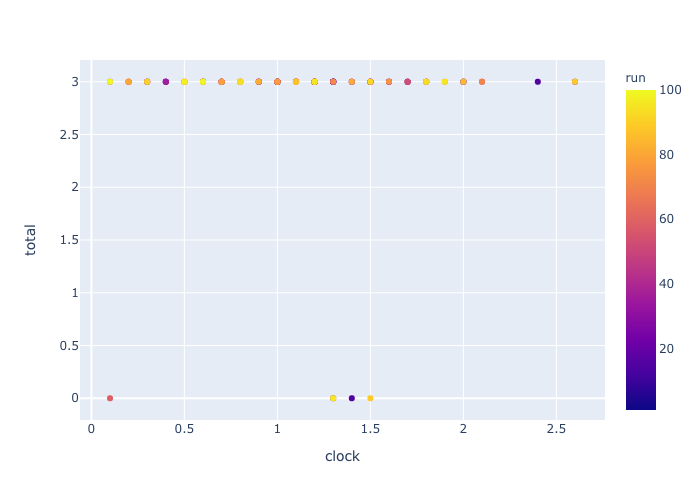

In [11]:
fig = px.scatter(df, x='clock', y='total', color='run', hover_data=['op','success'])
fig.show()

#fig.write_image("test.png")
#Image('test.png')

In [17]:
df[df["score"] > 0].describe()

,run,clock,score,total
count,100.000000,100.000000,100.0,100.0
mean,50.500000,1.123000,3.0,3.0
std,29.011492,0.546218,0.0,0.0
min,1.000000,0.100000,3.0,3.0
25%,25.750000,0.700000,3.0,3.0
50%,50.500000,1.100000,3.0,3.0
75%,75.250000,1.425000,3.0,3.0
max,100.000000,2.600000,3.0,3.0
